In [1]:
import os

# if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
os.environ["KERAS_BACKEND"] = "torch"

print(f'Backend: {os.environ["KERAS_BACKEND"]}')

import sys
sys.path.append('../')


Backend: torch


Function Trials:

In [2]:
import bayesflow as bf

# import optuna

# ensure the backend is set


# import torch

functions_dir = os.getcwd() + '/functions'
sys.path.append(functions_dir)

import keras

import dmc_functions as dmc

import numpy as np
import math

import pickle
import sys
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

from numba import njit
# import re
# import matplotlib.pyplot as plt
# from datetime import datetime
# from functools import partial
# from keras.utils import to_categorical


2025-03-18 11:34:08.190262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 11:34:08.198190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742294048.211757  349334 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742294048.215869  349334 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742294048.225944  349334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742294048.225959  349334 computation_placer.cc:177] computation placer already registered. Please che

In [3]:
@njit
def trial(A, tau, mu_c, mu_r, b,
              tmax,
              sigma,
              dt,
            #   sd_r_var,
            #   a_var,
            #   x0_var,
              a= 2,
              X0_beta_shape_fixed = 3):

    # ['A', 'tau', 'mu_c', 'mu_r', 'b']
    # ['A', 'tau', 'mu_c', 'mu_r', 'b', 'a']
    # ['A', 'tau', 'mu_c', 'mu_r', 'b', 'sd_r']
    # ['A', 'tau', 'mu_c', 'mu_r', 'b', 'sd_r', 'a']

    #theta = prior_fun(context_alpha())

    # tau = theta[1]
    # mu_c = theta[2]
    # t0 = theta[3]
    # b = theta[4]

    # if sd_r_var == 'estimated':
    #     sd_r = theta[5]
    #     # if link_fun == 'normal cdf':
    #     #     mu_r = norm_cdf(mu_r, mu_r_prior_mean, mu_r_prior_sd)*90+290
    #     #     sd_r = norm_cdf(sd_r, sd_r_prior_mean, sd_r_prior_sd)*30+15
    #     t0 = np.random.normal(mu_r, sd_r)
    # elif sd_r_var == 'fixed':
    #     t0 = mu_r
    #     # if link_fun == 'normal cdf':
    #     #     t0 = norm_cdf(t0, t0_prior_mean, t0_prior_sd)*130+270

    # # a estimated or fixed
    # if a_var == 'estimated':
    #     a = theta[-1]
    # elif a_var == 'fixed':

    t0 = mu_r

    # if link_fun == 'normal cdf':
    #     A = norm_cdf(A, A_prior_mean, A_prior_sd)*25+15
    #     tau = norm_cdf(tau, tau_prior_mean, tau_prior_sd)*100+20
    #     mu_c = norm_cdf(mu_c, mu_c_prior_mean, mu_c_prior_sd)*0.6+0.2
    #     b = norm_cdf(b, b_prior_mean, b_prior_sd)*70+90

    # trial variability
    # if x0_var == 'trial':
    #     X0 = np.random.beta(X0_beta_shape_fixed, X0_beta_shape_fixed)*(2*b)-b
    # elif x0_var == 'fixed':
    #     X0 = X0_value
    X0 = np.random.beta(X0_beta_shape_fixed, X0_beta_shape_fixed)*(2*b)-b

    t = np.linspace(start=dt, stop=tmax, num=int(tmax / dt))
    mu = A * np.exp((-t / tau)) * (np.exp(1) * t / (a - 1) / tau)**(a - 1) * ((a - 1) / t - 1 / tau) + mu_c
    dX = mu * dt + sigma * np.sqrt(dt) * np.random.randn(len(t))
    X_shift = np.cumsum(dX) + X0

    #mua <- A/tau * np.exp(1 - t/tau) * (1 - t/tau)

    # plt.plot(t, X_shift)
    # #plt.xlim([0, d])
    # plt.axhline(y=b, color='r', linestyle='-')
    # plt.axhline(y=-b, color='r', linestyle='-')

    # mu_cum = np.cumsum(mu*dt)+X0
    # plt.plot(t, mu_cum)
    # plt.plot(t, X_shift)
    # plt.axhline(y=b, color='r', linestyle='-')
    # plt.axhline(y=-b, color='r', linestyle='-')

    if np.any(X_shift >= b) or np.any(X_shift <= -b):
        d = min(t[(X_shift >= b) | (X_shift <= -b)])

        rt = (d + t0)/1000

        boundary_hit = X_shift[np.where(t == d)][0]

        if boundary_hit >= b:
            # correct response
            resp = 1
        else:
            # wrong response
            resp = 0

    else:
        rt = resp = -1
    return rt, resp


# def condition_matrix(n_obs, n_conditions):
#     obs_per_condition = np.ceil(n_obs / n_conditions)
#     condition = np.arange(n_conditions)
#     condition = np.repeat(condition, obs_per_condition)
#     np.random.shuffle(condition)
#     return np.array(condition[:n_obs])


Experiment Function:

In [95]:
# @njit
def experiment(A, tau, mu_c, mu_r, b,
                # context,
                N,
                tmax = 1500,
                sigma = 4,
                dt = 1,
                # sd_r_var,
                # a_var,
                # x0_var,
                # a_value,
                # X0_value,
                # X0_beta_shape_fixed,
               nonconvergent_warning = True,
               max_nonconvergent = 1000):

    # n_obs = batchable_context.shape[0]
    n_conditions = 2
    obs_per_condition = int(np.ceil(N / n_conditions))
    condition = np.arange(n_conditions)
    condition = np.repeat(condition, obs_per_condition)
    np.random.shuffle(condition)

    out = np.zeros((int(N), 2))  # Ensure N is int
    context = condition[:int(N)].copy() 

    for n in range(0, int(N)):
        A_current = A if context[n] == 0 else -A
        # A = theta[0]
        rt = -1
        counter = 0
        while rt < 0:

            counter += 1

            rt, resp = trial(A_current, tau, mu_c, mu_r, b,
                             tmax = tmax,
                             sigma = sigma,
                             dt = dt,
                            #  sd_r_var = sd_r_var,
                            #  a_var = a_var,
                            #  x0_var = x0_var,
                            #  a_value = a_value,
                            #  X0_value = X0_value,
                             X0_beta_shape_fixed = 3)

            if counter > max_nonconvergent:
                if nonconvergent_warning:
                    print('WARNING: RESAMPLING DIFFUSION PROCESS DID NOT DIVERGE AFTER 100 REPETITIONS!')

                resp = -1

                break
        out[n, 0] = rt
        out[n, 1] = resp
    
    # context = context[:,np.newaxis]

    # context = np.concatenate((context, np.repeat(np.sqrt(N), N)[:,np.newaxis]), axis = 1)
        
    return dict(rt = out[:, 0], acc = out[:, 1], context = context, N = np.repeat(N, int(N)))
    # return out, context

In [96]:
# sim_batchable_fun = partial(dmc.condition_matrix, n_conditions = 2)

# sim_non_batchable_fun = partial(dmc.random_n_obs, min_obs = 50, max_obs = 1000)

# def condition_matrix(n_obs, n_conditions):
#     obs_per_condition = np.ceil(n_obs / n_conditions)
#     condition = np.arange(n_conditions)
#     condition = np.repeat(condition, obs_per_condition)
#     np.random.shuffle(condition)
#     return np.array(condition[:n_obs])

# context = condition_matrix(100, 2)


# context[0]

In [97]:
N = 333

n_conditions = 2
obs_per_condition = np.ceil(int(N) / n_conditions)
condition = np.arange(n_conditions)
condition = np.repeat(condition, obs_per_condition)
np.random.shuffle(condition)
out = np.zeros((int(N), 2))


context = np.array(condition[:int(N)])[:,np.newaxis]

context = np.concatenate((context, np.repeat(np.sqrt(N), N)[:,np.newaxis]), axis = 1)

context.shape
# n_vec.shape

(333, 2)

In [98]:
def prior():

    # A, tau, mu_c, mu_r, b
    means = np.array([16.37, 111.28, 0.53, 74.96, 322.82])
    sds = np.array([10.42, 47.41, 0.13, 22.64, 39.86])

    # theta = dmc.normal_lim(means, sds, restriction = 'positive_only')
    
    theta = np.random.normal(means, sds).astype('float32')

    return dict(A = theta[0],
                tau = theta[1],
                mu_c = theta[2],
                mu_r = theta[3],
                b = theta[4])


def prior_restr():

    # A, tau, mu_c, mu_r, b
    means = np.array([16.37, 111.28, 0.53, 74.96, 322.82])
    sds = np.array([10.42, 47.41, 0.13, 22.64, 39.86])

    theta = dmc.normal_lim(means, sds, restriction = 'positive_only')
    
    # theta = np.random.normal(means, sds).astype('float32')

    return dict(A = theta[0],
                tau = theta[1],
                mu_c = theta[2],
                mu_r = theta[3],
                b = theta[4])

# %timeit test_prior = prior()
test_prior = prior()
# %timeit test_prior_restr = prior_restr()

In [99]:
def meta_fun():

    N = int(np.random.randint(50, 1000))

    # n_obs = np.repeat(n, n)
    
    # condition_mat = condition_matrix(n_obs, 2)

    return dict(N = N)

test_meta = meta_fun()

# print(f"Test A Prior: {test_prior['A']}")
# print(f"Test Context: {test_meta['context']}")
print(f"Test N_OBS: {test_meta['N']}")

print(f"Test N_OBS first element: {test_meta['N']}")

Test N_OBS: 528
Test N_OBS first element: 528


In [101]:

start_time = time.time()
data_set = experiment(test_prior['A'], 
                      test_prior['tau'],
                      test_prior['mu_c'],
                      test_prior['mu_r'],
                      test_prior['b'],
                      test_meta['N'])
end_time = time.time()
print(f"Computation 1 Data set takes {round(end_time-start_time, 3)} ms")

print(f"{data_set['rt'].shape}")
print(f"{data_set['acc'].shape}")
print(f"{data_set['context'].shape}")
print(f"{data_set['N'].shape}")


Computation 1 Data set takes 0.044 ms
(528,)
(528,)
(528,)
(528,)


In [102]:

test_prior = prior()

# %timeit experiment(test_prior['A'], test_prior['tau'], test_prior['mu_c'], test_prior['mu_r'], test_prior['b'],test_meta['N'])

In [103]:
simulator = bf.simulators.make_simulator([prior, experiment], meta_fn = meta_fun)
simulator

In [104]:
num_sims = 10

start_time = time.time()

test_simulator = simulator.sample(num_sims)

end_time = time.time()
print(f"Computation per Data set takes {round((end_time-start_time)/num_sims, 3)} ms")

Computation per Data set takes 0.012 ms


In [106]:
# print(f"Number of Observations: {test_simulator['N']}")
print(f"Number of Observations shape: {test_simulator['N']}")
# print(f"Number of Observations shape: {test_simulator['N'].shape}")
print(f"A Prior shape: {test_simulator['A'].shape}")
print(f"tau Prior shape: {test_simulator['tau'].shape}")
print(f"RT shape: {test_simulator['rt'].shape}")
print(f"Accuracy shape: {test_simulator['acc'].shape}")

print(f"Context shape: {test_simulator['context'].shape}")
print(f"N shape: {test_simulator['N'].shape}")

# print(f"Congruency shape: {test_simulator['congruency'].shape}")

Number of Observations shape: [[125 125 125 ... 125 125 125]
 [125 125 125 ... 125 125 125]
 [125 125 125 ... 125 125 125]
 ...
 [125 125 125 ... 125 125 125]
 [125 125 125 ... 125 125 125]
 [125 125 125 ... 125 125 125]]
A Prior shape: (10, 1)
tau Prior shape: (10, 1)
RT shape: (10, 125)
Accuracy shape: (10, 125)
Context shape: (10, 125)
N shape: (10, 125)


In [107]:

par_keys = ["A", "tau", "mu_c", "mu_r", "b"]

par_names = [r'$A$', r'$\tau$', r'$\mu_c$',r'$\mu_r$', r'$b$']



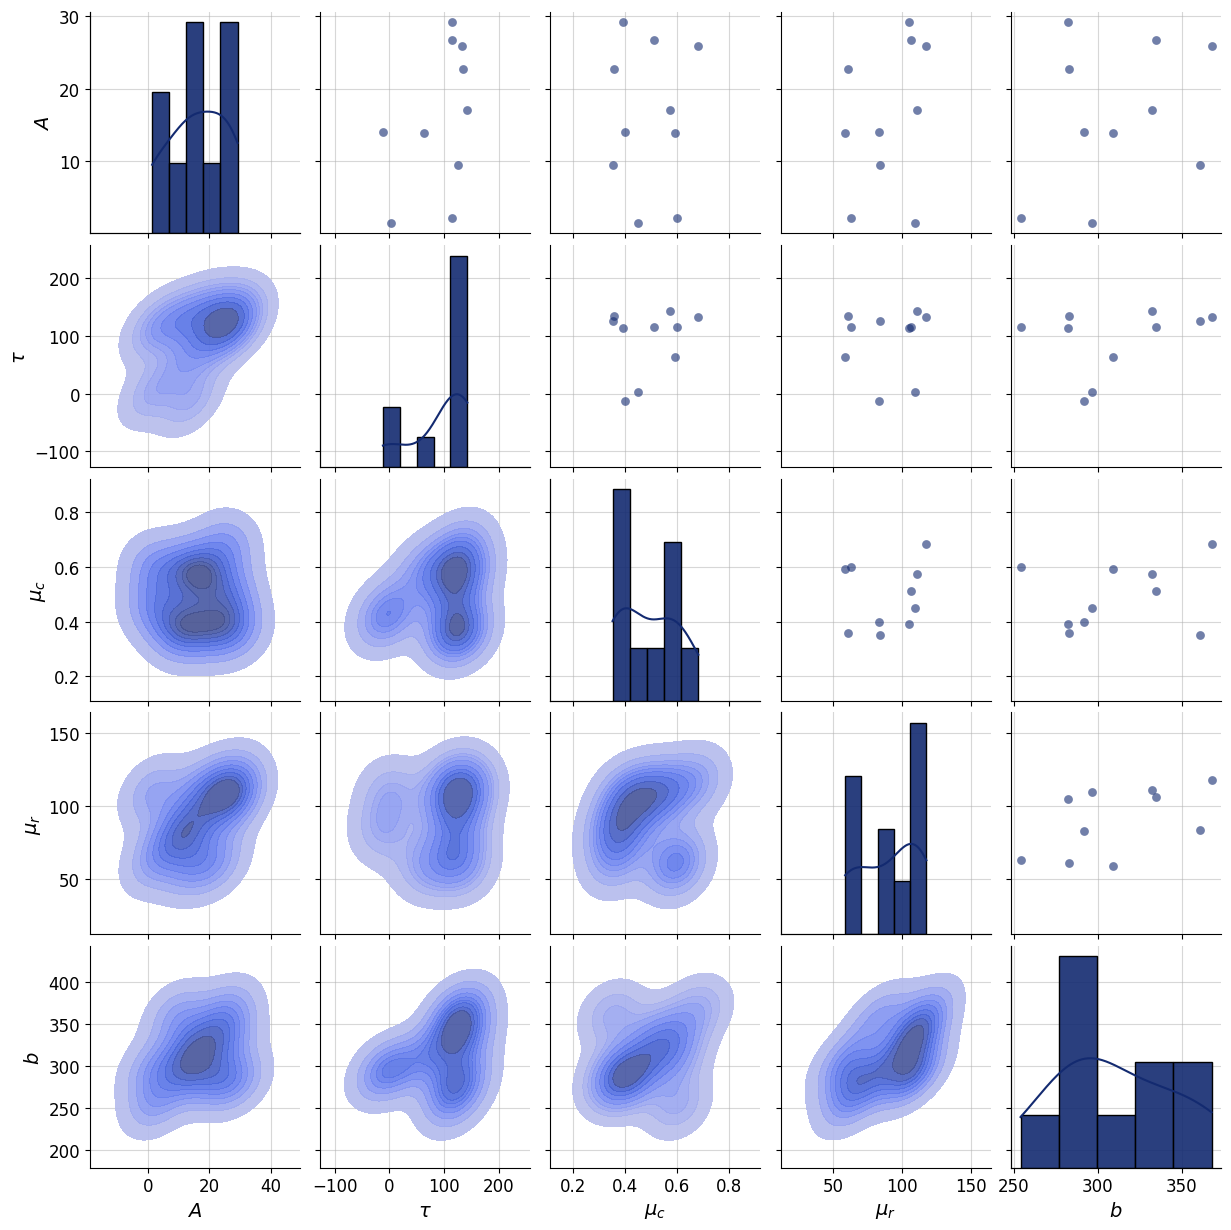

In [108]:


f = bf.diagnostics.plots.pairs_samples(
    samples=test_simulator,
    variable_keys=par_keys,
    variable_names=par_names
)



In [143]:
# adapter = (
#     bf.Adapter()
#     .to_array()
#     .convert_dtype("float64", "float32")
#     .broadcast("N", to="rt")
#     .broadcast("N", to="context")  
#     .sqrt('N')
#     .as_set(["rt", "acc"])
#     .concatenate(["A", "tau", "mu_c", "mu_r", "b"], into="inference_variables")
#     .concatenate(["rt", "acc"], into="summary_variables")
#     .apply("N", lambda x: np.repeat(x, repeats=N, axis=1)[..., None])
#     # .rename("N", "inference_conditions")
#     .concatenate(["N", "context"], into="inference_conditions", ax) 
# )

adapter = (
    bf.Adapter()
    .to_array()
    .convert_dtype("float64", "float32")
    # .constrain(["A", "tau", "mu_c", "mu_r", "b"], lower = 0)
    # .broadcast("N", to="context")  # Broadcast N to match context's shape
    .sqrt('N')
    # .broadcast("N", to="rt")
    .standardize(include = ["A", "tau", "mu_c", "mu_r", "b"])
    .as_set(["rt", "acc", "context"])
    .concatenate(["A", "tau", "mu_c", "mu_r", "b"], into="inference_variables")
    .concatenate(["rt", "acc", 'context'], into="summary_variables")
    .concatenate(["N"], into="inference_conditions")
    # .rename("N","inference_conditions")  # Concatenate both variables
)

# adapter.broadcast

test_data =simulator.sample(10)

processed_draws = adapter(test_data)


In [144]:


# processed_draws = adapter(test_simulator)
print(processed_draws["summary_variables"].shape)
print(processed_draws["inference_conditions"].shape)
print(processed_draws["inference_variables"].shape)
# print(processed_draws["N"].shape)
processed_draws.keys()

# processed_draws["inference_conditions"]

(10, 339, 3)
(10, 339)
(10, 5)


dict_keys(['inference_variables', 'summary_variables', 'inference_conditions'])

In [145]:
print(processed_draws["inference_variables"])

[[-0.71913815  1.1405367  -0.73497516 -1.1612777   0.9856689 ]
 [ 0.86978966 -0.47733712  0.84517646  0.859435   -0.8377469 ]
 [-0.00252455  0.2568317   0.3340719  -0.3308287  -0.6566895 ]
 [-0.03076777  0.43581387  0.6221014   0.86018956  1.1681234 ]
 [-0.97436464 -1.0742952  -0.41013867 -1.2472817  -0.7713234 ]
 [ 2.089566    0.71178544 -1.9598525   0.0226124  -1.4670111 ]
 [-0.00253787 -0.12234817 -0.2235903   0.9783323   0.05101668]
 [ 0.32523766 -0.9873255   1.7539241   0.05405176  1.6639842 ]
 [-0.03787525 -1.4514886  -0.32035756 -1.3492585  -0.02848418]
 [-1.5173857   1.567827    0.09363674  1.3140223  -0.10754372]]


In [146]:
# num_training_batches = 128
# num_validation_batches = 16
# batch_size = 16
# epochs = 1



# training_data = simulator.sample(num_training_batches * batch_size,)
# validation_data = simulator.sample(num_validation_batches * batch_size,)


In [147]:
# summary_net = bf.networks.transformers.SetTransformer(summary_dim = 32)
 
# summary_net = bf.networks.transformers.SetTransformer(summary_dim = 32)
 
# inference_network = bf.networks.CouplingFlow(subnet="mlp", transform="spline", depth=12)

# summary_network = bf.networks.SetTransformer(summary_dim=32)
     
# inference_network = bf.networks.CouplingFlow()
# inference_network = bf.networks.CouplingFlow()


In [148]:


# approximator = bf.ContinuousApproximator(
#    inference_network=inference_network,
#    summary_network=summary_network,
#    adapter=adapter
# )

# approximator.compute_output_shape
     


In [149]:
# epochs = 100
# num_batches = 1000
# batch_size = 16
# learning_rate = keras.optimizers.schedules.CosineDecay(5e-4, decay_steps=epochs*num_batches, alpha=1e-6)
# optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
# approximator.compile(optimizer=optimizer)
     


In [170]:
num_training_batches = 128
num_validation_batches = 16
batch_size = 16
epochs = 5


validation_data = simulator.sample(64)


In [171]:
validation_data.keys()

dict_keys(['N', 'A', 'tau', 'mu_c', 'mu_r', 'b', 'rt', 'acc', 'context'])

In [172]:
ordered_keys = ['rt', 'acc', 'context', 'N', 'A', 'tau', 'mu_c', 'mu_r', 'b']
validation_data = {key: validation_data[key] for key in ordered_keys}


In [173]:
validation_data.keys()

dict_keys(['rt', 'acc', 'context', 'N', 'A', 'tau', 'mu_c', 'mu_r', 'b'])

In [174]:
print(f"N simulator: {validation_data['N']}")
print(f"N shape adapter: {adapter(validation_data)['inference_conditions'].shape}")

N simulator: [[550 550 550 ... 550 550 550]
 [550 550 550 ... 550 550 550]
 [550 550 550 ... 550 550 550]
 ...
 [550 550 550 ... 550 550 550]
 [550 550 550 ... 550 550 550]
 [550 550 550 ... 550 550 550]]
N shape adapter: (64, 550)


In [175]:
# convert to offline data set

val_dataset = bf.datasets.OfflineDataset(
    data=validation_data, 
    batch_size=batch_size, 
    adapter=adapter
)

In [176]:
training_data = simulator.sample(64)

In [177]:
training_data.keys()

dict_keys(['N', 'A', 'tau', 'mu_c', 'mu_r', 'b', 'rt', 'acc', 'context'])

In [178]:
ordered_keys = ['rt', 'acc', 'context', 'N', 'A', 'tau', 'mu_c', 'mu_r', 'b']
training_data = {key: training_data[key] for key in ordered_keys}

training_data.keys()

adapter(training_data).keys()

dict_keys(['inference_variables', 'summary_variables', 'inference_conditions'])

In [179]:
print(f"N simulator: {training_data['N']}")
print(f"N shape adapter: {adapter(training_data)['inference_conditions'].shape}")

N simulator: [[960 960 960 ... 960 960 960]
 [960 960 960 ... 960 960 960]
 [960 960 960 ... 960 960 960]
 ...
 [960 960 960 ... 960 960 960]
 [960 960 960 ... 960 960 960]
 [960 960 960 ... 960 960 960]]
N shape adapter: (64, 960)


In [180]:
# reformat to offline data
train_dataset = bf.datasets.OfflineDataset(
    data=training_data, 
    batch_size=batch_size, 
    adapter=adapter
)

In [181]:
type(train_dataset)

bayesflow.datasets.offline_dataset.OfflineDataset

In [182]:
train_dataset.num_batches

4

In [183]:
# train_dataset.__getitem__(1)
item = 1
item = slice(item * batch_size, (item + 1) * batch_size)

print(f"item: {item}")


item: slice(16, 32, None)


In [184]:
item = train_dataset.indices[item]

In [185]:
iterator = iter(train_dataset.data.items())

# Loop through and get all items
for item in iterator:
    print(item)

('rt', array([[1.51275058, 0.79275058, 0.42675058, ..., 0.23975058, 0.62875058,
        0.28475058],
       [0.34064071, 0.56264071, 0.70764071, ..., 0.87364071, 0.84364071,
        0.36964071],
       [0.71929182, 0.78829182, 0.49029182, ..., 0.53029182, 0.26129182,
        0.85729182],
       ...,
       [1.24244219, 1.54044219, 0.93644219, ..., 0.55644219, 0.73544219,
        0.47944219],
       [0.31578893, 0.44778893, 0.69478893, ..., 1.36778893, 0.14878893,
        0.91778893],
       [0.50545653, 0.50745653, 0.62245653, ..., 0.47345653, 0.34845653,
        0.42245653]]))
('acc', array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]))
('context', array([[0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [1, 1,

In [168]:

# for item in iterator:
#     key, value = next(iter(train_dataset.data.items()))

#     print(f"key: {key}, value: {value}")

In [ ]:
# np.take(value, item, axis = 0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
# batch = {key: np.take(value, item, axis=0) for key, value in train_dataset.data.items()}

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [94]:
key

'rt'

In [188]:
dropout = 0.05
initial_learning_rate = 5e-4

# Create inference net
# sigma2 = keras.ops.var(train_samples["parameters"].astype("float32"), axis=0, keepdims=True)

inference_network = bf.networks.CouplingFlow(subnet="mlp", transform="spline", depth=12)

summary_net = bf.networks.transformers.SetTransformer(summary_dim = 32)

# Create optimizer
scheduled_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=epochs*train_dataset.num_batches,
    alpha=1e-8
)
optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)


# Create approximator
approximator = bf.ContinuousApproximator(
   inference_network=inference_network,
   summary_network=summary_net,
   adapter=adapter
)

approximator.compile(optimizer=optimizer)
# Train and compute the average of last 5 validation losses
history = approximator.fit(
    epochs=epochs,
    dataset=train_dataset,
    validation_data=val_dataset
    # verbose=0
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - loss: 7154398.5000 - loss/inference_loss: 7154398.5000 

ValueError: Exception encountered when calling ConfigurableHiddenBlock.call().

[1mInput 0 of layer "dense_87" is incompatible with the layer: expected axis -1 of input shape to have value 994, but received input with shape (16, 584)[0m

Arguments received by ConfigurableHiddenBlock.call():
  • inputs=torch.Tensor(shape=torch.Size([16, 584]), dtype=float32)
  • training=False
  • kwargs=<class 'inspect._empty'>

In [479]:
### define objective function

def objective(epochs=30):
    
    # Hardcode hyperparameters
#     max_time = 10
#     width = 256
#     depth = 6
    dropout = 0.05
    initial_learning_rate = 5e-4
    
    # Create inference net
    # sigma2 = keras.ops.var(train_samples["parameters"].astype("float32"), axis=0, keepdims=True)
    
    inference_network = bf.networks.CouplingFlow(subnet="mlp", transform="spline", depth=12)

    summary_net = bf.networks.transformers.SetTransformer(summary_dim = 32)

    # Create optimizer
    scheduled_lr = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=epochs*train_dataset.num_batches,
        alpha=1e-8
    )
    optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)
    
    
    # Create approximator
    approximator = bf.ContinuousApproximator(
        inference_network=inference_network,
        summary_network=summary_net,
        adapter=adapter,
    )
    approximator.compile(optimizer=optimizer)
    
    # Train and compute the average of last 5 validation losses
    history = approximator.fit(
        epochs=epochs,
        dataset=train_dataset,
        validation_data=val_dataset,
        verbose=0
    )
    return np.mean(history.history["val_loss"][-5:])


In [480]:
print("Validation loss: {}".format(objective()))

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


IndexError: index 435 is out of bounds for axis 0 with size 1

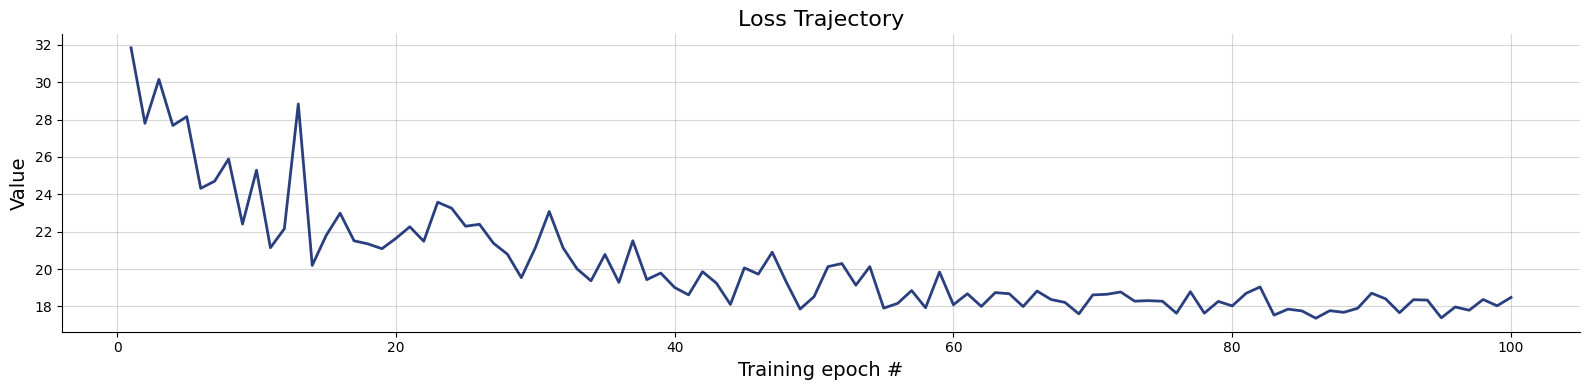

In [50]:
f = bf.diagnostics.plots.loss(history)


In [51]:

# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data (unseen during training)
val_sims = simulator.sample(200)

# Obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = approximator.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys() 



dict_keys(['A', 'tau', 'mu_c', 'mu_r', 'b'])

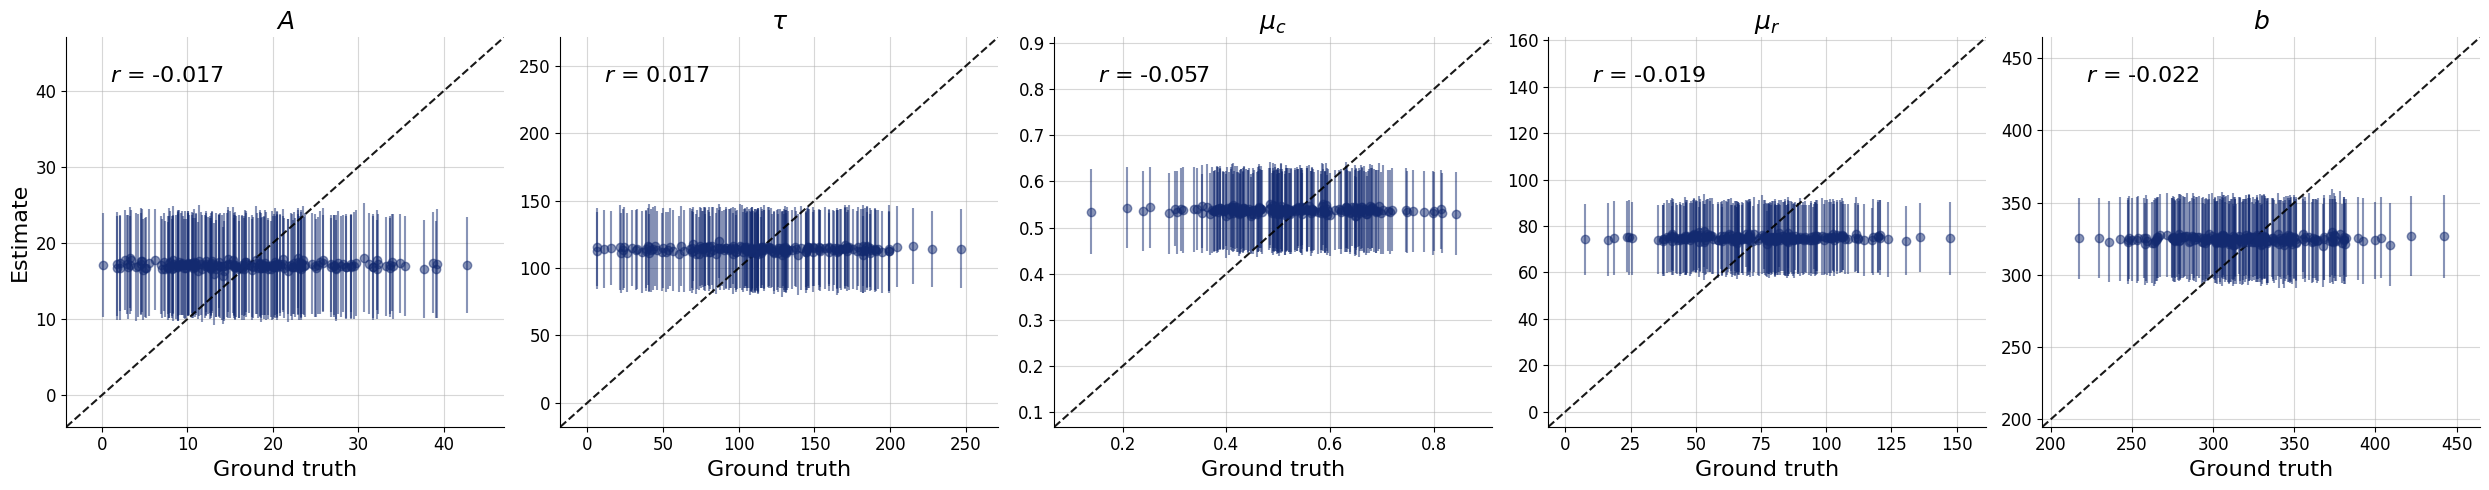

In [52]:


f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)



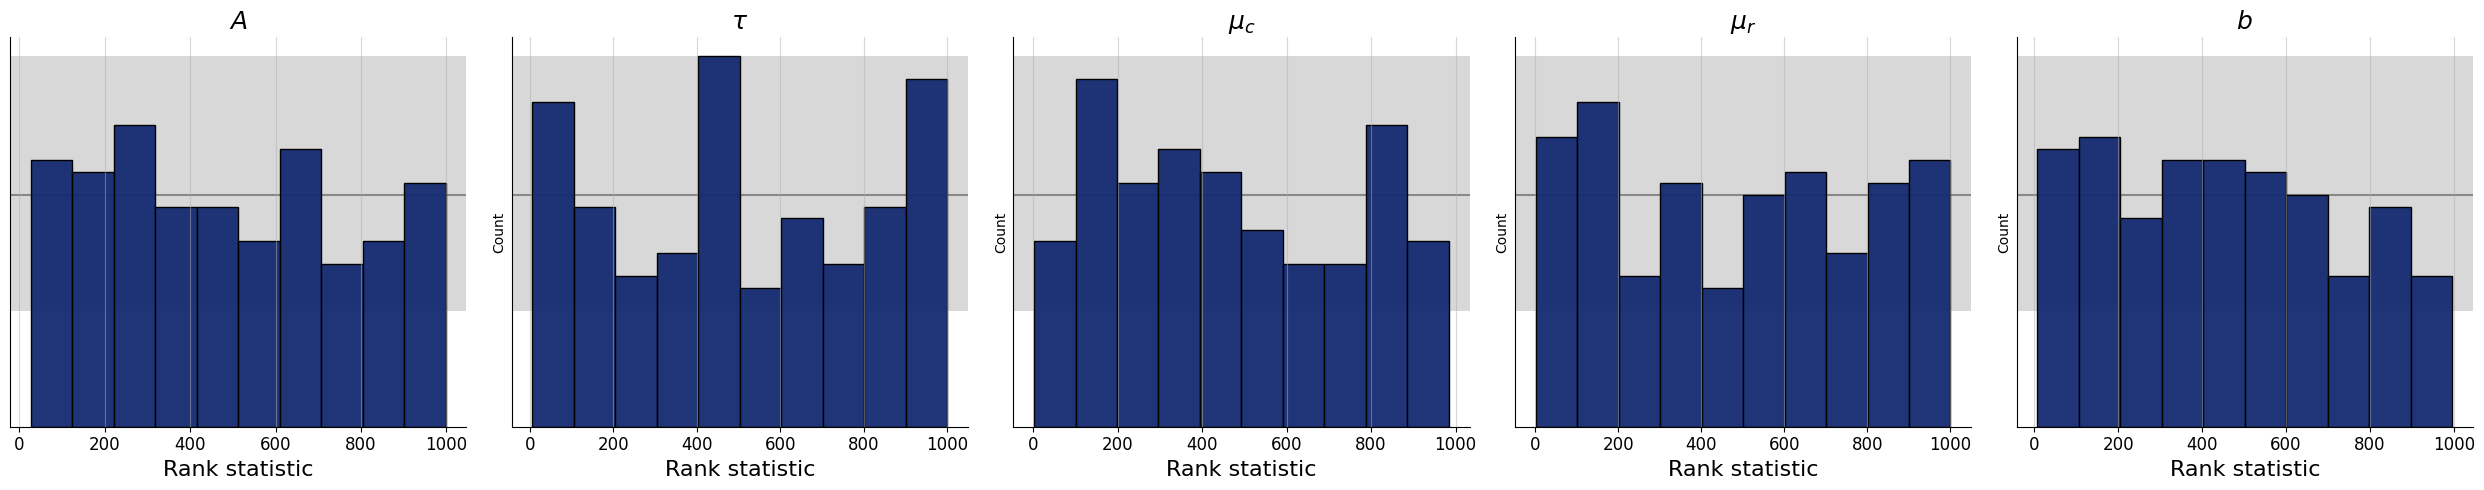

In [53]:


f = bf.diagnostics.plots.calibration_histogram(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)



In [136]:
def objective(epochs=5):
    
    # Hardcode hyperparameters
    # max_time = 10
    # width = 256
    # depth = 6
    # dropout = 0.05
    initial_learning_rate = 5e-4
    
    # Create inference net
    inference_network = bf.networks.CouplingFlow()

    # Create Summary Net
    summary_network = bf.networks.SetTransformer()
    
    
    # Create optimizer
    scheduled_lr = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=epochs*int(training_data['rt'].shape[0]/batch_size),
        alpha=1e-8
    )
    optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)

    
    
    # Create approximator
    approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    summary_network=summary_network,
    adapter=adapter)


    approximator.compile(optimizer=optimizer)
    
    # Train and compute the average of last 5 validation losses
    history = approximator.fit(
        epochs=epochs,
        dataset=training_data,
        validation_data=validation_data,
        verbose=0
    )
    # return np.mean(history.history["val_loss"][-5:])
